### Integration with a quantum circuit and automatic differentiation

In this tutorial we exploit the automatic differentiation of our quantum model with respect to the input data to perform the calculation of integrals.

---

The core idea is inspired by [J. M. Cruz-Martinez et al.](https://iopscience.iop.org/article/10.1088/2058-9565/ad5866) and consists in training the derivative of a quantum circuit output w.r.t. input data to approximate the integrand function of a target integration problem. Once the derivative of the circuit is trained to approximate the integrand, then the original circuit can be used to compute any definite integral value by applying the fundamental theorem of the integral calculus.

$$ I = \int g(x) dx $$

In [237]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

We consider a dummy 1-dimensional target here.

In [245]:
def integrand_function(x):
    return 1/2*x + torch.sin(3 * x)

def integral_function(x):
    return x ** 2 / 4 - torch.cos(3 * x)/3 

def definite_integral(xa, xb):
    return integral_function(xb) - integral_function(xa)

npoints = 50
nqubits = 1
nlayers = 5

In [246]:
x = torch.linspace(0, 2, npoints)
g = integrand_function(x)
I = integral_function(x)

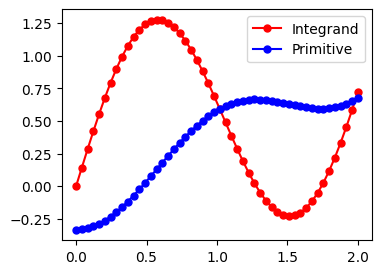

In [261]:
plt.figure(figsize=(4, 3))
plt.plot(x, g, label="Integrand", c="red", marker=".", markersize=10)
plt.plot(x, I, label="Primitive", c="blue", marker=".", markersize=10)
plt.legend()
plt.show()

Then we use a data reuploading strategy to upload the data into a quantum circuit, alternating data-encoding gates with trainable blocks of gates in our circuit. 

[Qibo 0.2.17|INFO|2025-03-21 15:53:46]: Using qiboml (pytorch) backend on cpu


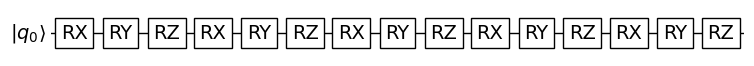

In [285]:
x_train = torch.linspace(0., 2., npoints, dtype=torch.float64).unsqueeze(1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = integrand_function(x_train)

set_backend("qiboml", platform="pytorch")


# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
)

circuit_structure = []
for _ in range(nlayers):
    circuit_structure.extend(
        [encoding_circ, trainable_circuit(entanglement=True)]
    )

# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
)

model.draw()

optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99))
criterion = nn.MSELoss()

def prediction(model, x_i):
    y_pred = model(x_i)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_i,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
        retain_graph=True,
        allow_unused=True,
    )[0]
    return dydx

def loss_function(model, x, target):
    losses = []
    # Process each sample separately.
    for x_i, target_i in zip(x, target):
        # x_i and target_i are single samples (with proper shape)
        dydx = prediction(model, x_i)
        losses.append(criterion(dydx, target_i.unsqueeze(0)))
    return torch.stack(losses).mean()


We have a look to a first random guess of our model.

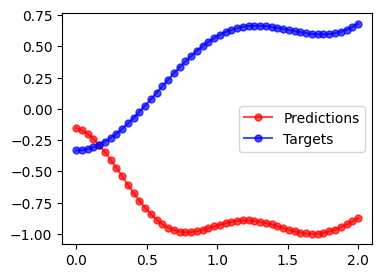

In [286]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

In [287]:
for epoch in range(200):
    optimizer.zero_grad()
    
    # Compute loss using the wrapped loss function
    loss = loss_function(model, x_train, y_train)
    
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 1.7300206281100778
Epoch 5: Loss = 0.23842558993618554
Epoch 10: Loss = 0.058099779244896954
Epoch 15: Loss = 0.12113062040013349
Epoch 20: Loss = 0.05559872332740716
Epoch 25: Loss = 0.03683990395636157
Epoch 30: Loss = 0.02298963510236727
Epoch 35: Loss = 0.018229736321729816
Epoch 40: Loss = 0.015552951161580411
Epoch 45: Loss = 0.01383737805253455
Epoch 50: Loss = 0.011569777490536169
Epoch 55: Loss = 0.010075749011494545
Epoch 60: Loss = 0.009556559306138093
Epoch 65: Loss = 0.008227390141318689
Epoch 70: Loss = 0.007582713964118193
Epoch 75: Loss = 0.0068048397564298094
Epoch 80: Loss = 0.006032000838951127
Epoch 85: Loss = 0.00540891623415203
Epoch 90: Loss = 0.004761035790182593
Epoch 95: Loss = 0.00421062957720449
Epoch 100: Loss = 0.0036998190651934743
Epoch 105: Loss = 0.0032485554123061868
Epoch 110: Loss = 0.0028548347749282766
Epoch 115: Loss = 0.0025232091223648355
Epoch 120: Loss = 0.0022443546732478755
Epoch 125: Loss = 0.002020161419152603
Epoch 130: L

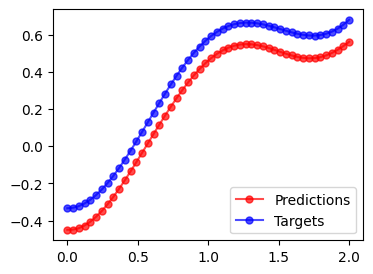

In [288]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

As expected, the solution is good but for a constant value. This is not a problem, because we need to use the model to compute definite integral values as follows:

In [289]:
x_a = torch.tensor(0.2345)
x_b = torch.tensor(1.8)

print(
    "Def integral exact:", 
    definite_integral(x_a, x_b)
)
print(
    "Approx integral:", 
     (model(x_b) - model(x_a)).squeeze().detach().numpy()
)

Def integral exact: tensor(0.8389)
Approx integral: 0.8361440809031371
